In [2]:
from brainiak.factoranalysis.tfa import TFA
from brainiak.factoranalysis.htfa import HTFA
import nilearn.plotting as niplot
from nilearn.input_data import NiftiMasker
import nibabel as nib
import numpy as np
import seaborn as sns
import hypertools as hyp

#import zipfile
import os
import sys
import glob
from mpi4py import MPI
import urllib.request

from IPython.display import YouTubeVideo

%matplotlib notebook

# Background and overview #

We'll be learning how to create movies of dynamic brain networks using single-subject and multi-subject fMRI data.  After getting the dataset and wrangling it into the proper format, there are three basic steps:
1. Use Hierarchical Topographic Factor Analysis (HTFA) to obtain a set of network "hubs," and the moment-by-moment hub activations.  Model details may be found [here](http://www.biorxiv.org/content/early/2017/02/07/106690).  This creates a simplified version of the full-brain data that is especially useful for computing dynamic network patterns.
1. Use the hub activactions to compute the moment-by-moment connectivity matrix reflected by the data.  We will be using a modified version of Inter-Subject Functional Connectivity (ISFC), which you can read more about [here](https://docs.wixstatic.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf).
1. Use [nilearn](http://nilearn.github.io/) and [hypertools](http://hypertools.readthedocs.io/en/latest/) to visualize the results and create pretty animations.

## Experiment ##
We'll be exploring a part of a dataset collected by Uri Hasson's lab.  The experiment had 36 participants listen *Pie Man*, a story told by Jim O'Grady as part of *The Moth* live storytelling event.  You can listen to the story here:

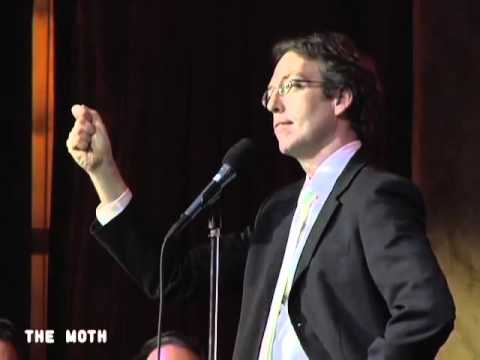

In [2]:
YouTubeVideo('3nZzSUDECLo')

## Data ##
The dataset comprises 36 preprocessed .nii files, and may be downloaded [here](http://dataspace.princeton.edu/jspui/handle/88435/dsp015d86p269k).  However, in the interest of running the analyses quickly, for this tutorial we're going to be working with data from just 4 participants participants.  This smaller dataset may be downloaded [here](https://dartmouth.box.com/s/535yzfqvsmfdiy9jrl65bb5x6rtc7ss4).

## Other datasets to explore ##
[This repository](http://dataspace.princeton.edu/jspui/handle/88435/dsp0147429c369) has a bunch of interesting fMRI datasets in the same format as the sample dataset we'll explore below.

[This dataset](https://dartmouth.box.com/s/gs30hsyk6gsmr8oe5993fr10kuacluo7) collected by Jim Haxby's lab comprises fMRI data as people watched *Indiana Jones: Raiders of the Lost Ark*.



In [3]:
#Download the data (takes a few minutes...)

#change these lines if you want to download a different dataset!

#source = 'https://drive.google.com/file/d/0ByrLHQFMZNefS3dZc08tTjBtclk/view?usp=sharing'
#source = 'https://www.dropbox.com/s/9tleak03otx4i42/PieMan_intact_mini.zip?dl=0'
source = 'https://www.dropbox.com/s/1hsln4kpd8x5rhl/PieMan_intact_mini.tar.gz?dl=0'
destination = '/mnt/pieman_data.tar.gz' #PieMan_intact_mini.zip'
data_format = 'tar.gz'

#urllib.request.urlretrieve(source, destination)



In [4]:
#Unzip the data
#zipfile.ZipFile(destination, 'r').extractall()
niifiles = glob.glob(os.path.join(destination[0:-(len(data_format)+1)], '*.nii.gz'))
niifiles.extend(glob.glob(os.path.join(destination[0:-7], '*.nii')))

### Data formatting: .nii --> matrix format ###
To computing HTFA-derived brain networks, we're going to first convert the .nii files into [CMU format](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/README-data-documentation.txt), inspired by Tom Mitchell's website for his 2008 Science paper on predicting brain responses to common nouns ([link](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html)).

We'll create a dictionary for each .nii (or .nii.gz) file with two elements:
- `Y`: a number-of-timepoints by number-of-voxels matrix of voxel activations
- `R`: a number-of-voxels by 3 matrix of voxel locations

In [46]:
def nii2cmu(nifti_file, mask_file=None):
    def fullfact(dims):
        '''
        Replicates MATLAB's fullfact function (behaves the same way)
        '''
        vals = np.asmatrix(range(1, dims[0] + 1)).T
        if len(dims) == 1:
            return vals
        else:
            aftervals = np.asmatrix(fullfact(dims[1:]))
            inds = np.asmatrix(np.zeros((np.prod(dims), len(dims))))
            row = 0
            for i in range(aftervals.shape[0]):
                inds[row:(row + len(vals)), 0] = vals
                inds[row:(row + len(vals)), 1:] = np.tile(aftervals[i, :], (len(vals), 1))
                row += len(vals)
            return inds
    
    img = nib.load(nifti_file)
    mask = NiftiMasker(mask_strategy='background')
    if mask is None:
        mask.fit(nifti_file)
    else:
        mask.fit(mask_file)
    
    hdr = img.header
    S = img.get_sform()
    vox_size = hdr.get_zooms()
    im_size = img.shape
    
    if len(img.shape) > 3:
        N = img.shape[3]
    else:
        N = 1
    
    Y = np.float64(mask.transform(nifti_file)).copy()
    vmask = np.nonzero(np.array(np.reshape(mask.mask_img_.dataobj, (1, np.prod(mask.mask_img_.shape)), order='C')))[1]
    vox_coords = fullfact(img.shape[0:3])[vmask, ::-1]-1

    R = np.array(np.dot(vox_coords, S[0:3, 0:3])) + S[:3, 3]
    
    return {'Y': Y, 'R': R}

In [47]:
mask = niifiles[0] #set to None if you don't want the images to match
cmu_data = list(map(lambda n: nii2cmu(n, mask),  niifiles))

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


## Voxel locations

We can get explore the nitty-gritties of the data by visualizaing the voxel activations and voxel locations.  For example, let's try plotting the voxel locations (`R`) for the first subject:

<IPython.core.display.Javascript object>


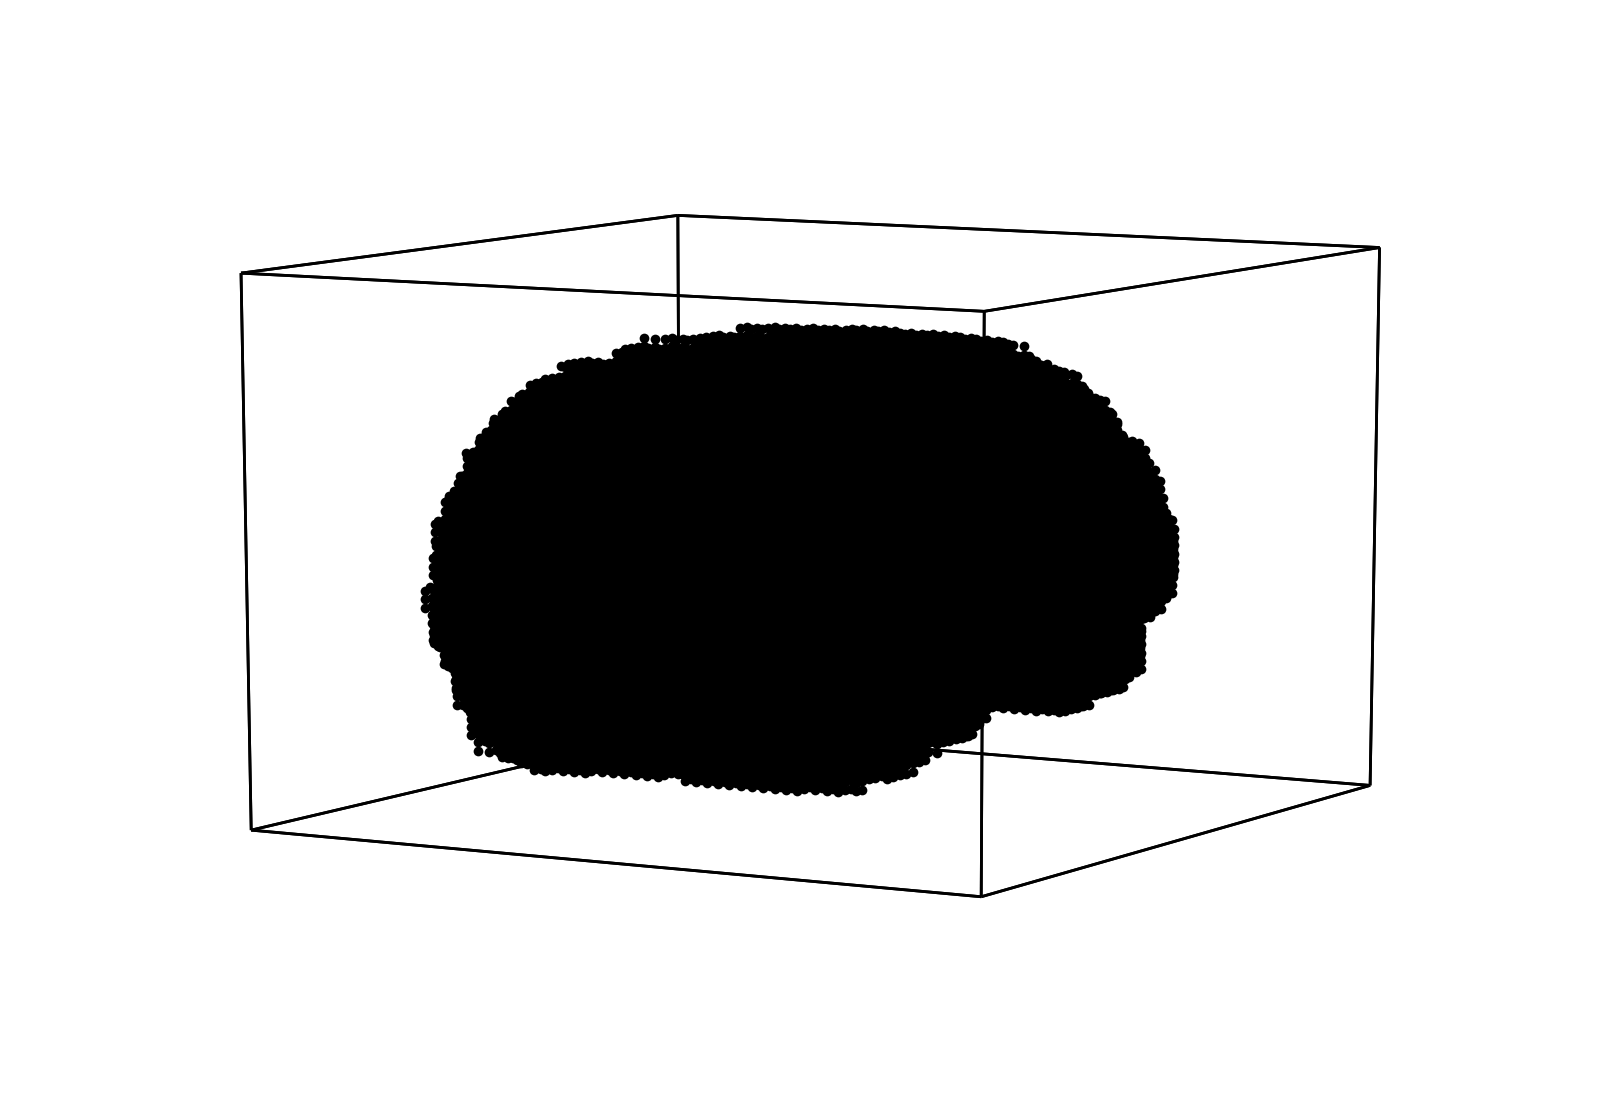

In [48]:
locations = hyp.plot(cmu_data[0]['R'], 'k.') #fun fact: also returns the voxel locations

## Voxel activations

And now let's plot a sample of voxel activations.  For fun, let's plot the first subject's data as a trajectory using HyperTools.  We'll first project the data down to 3 dimensions using Incremental PCA.  HyperTools supports a wide variety of dimensionality reduction algorithms (more info [here](http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot)).  Try changing the next cell to reduce the data using Multidimensional Scaling (`model='MDS'`) or creating an animation (`animate=True`).

<IPython.core.display.Javascript object>


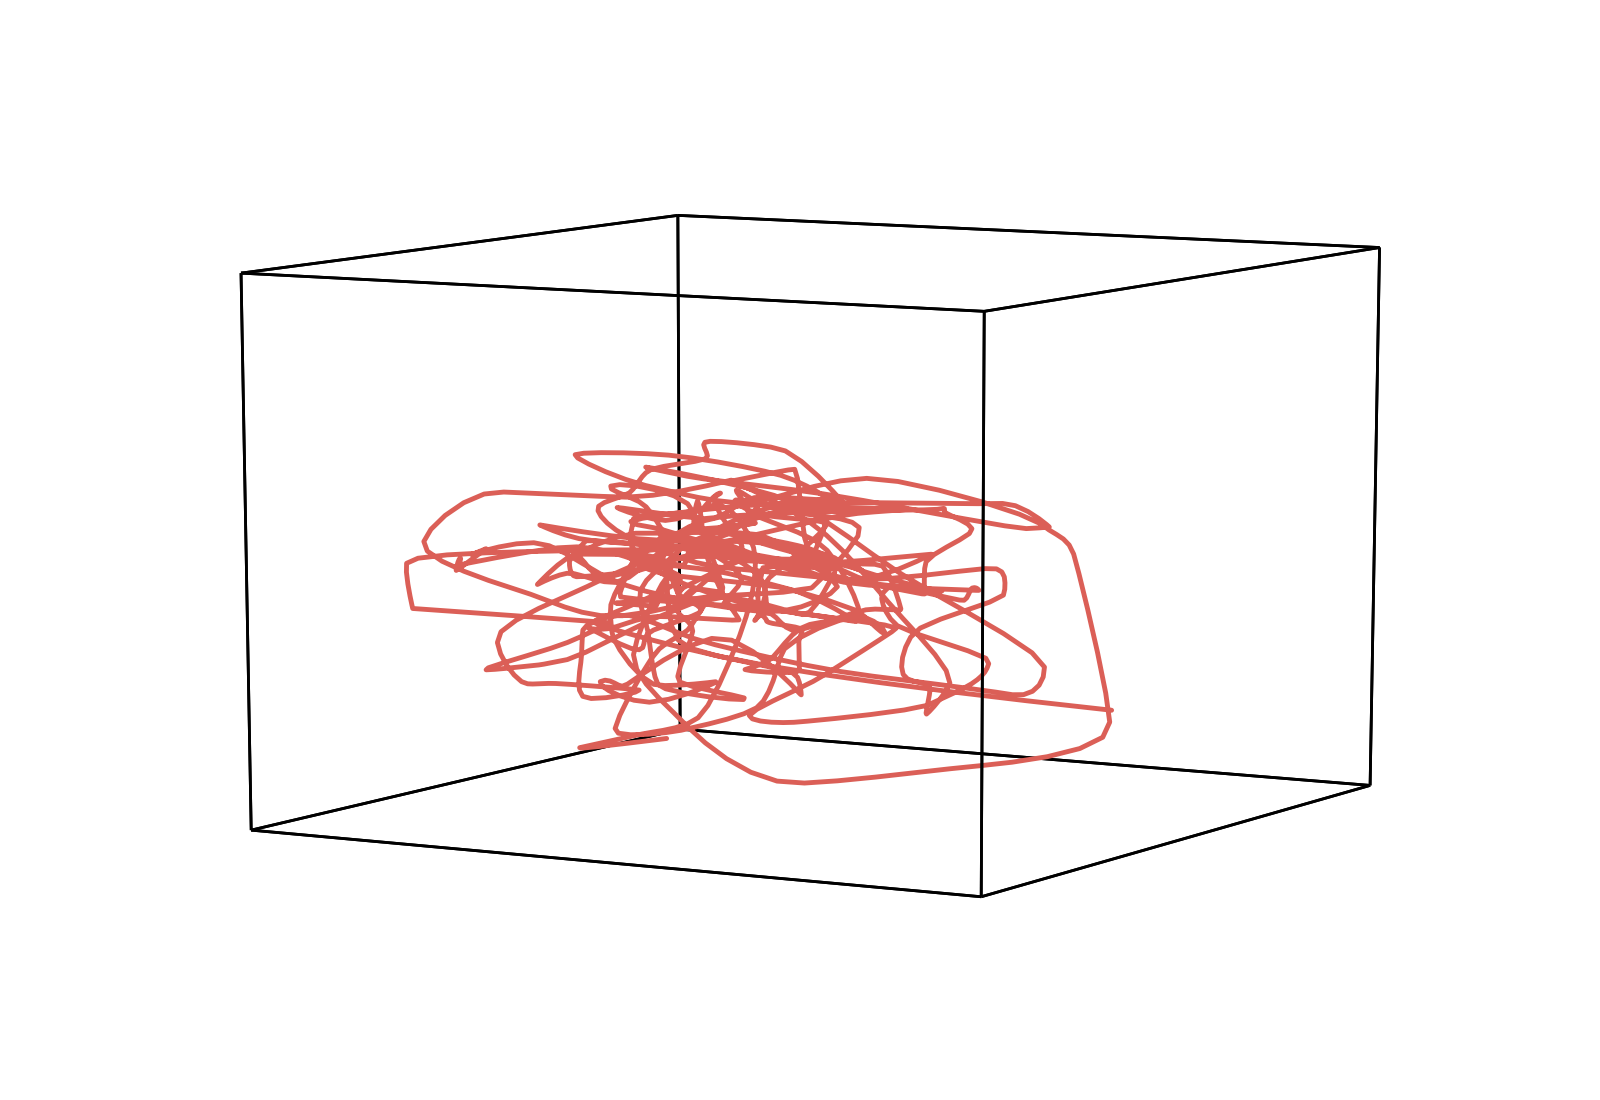

In [49]:
activations = hyp.plot(cmu_data[0]['Y'], model='IncrementalPCA')

## Converting between (timepoints by voxels) and (voxels by timepoints) data matrices ##

HyperTools and nilearn expect the data matrices to have number-of-timepoints rows and number-of-voxels columns.  BrainIAK expects the data in the transpose of that format-- number-of-voxels by number-of-timepoints matrices.  We can easily convert between the two formats using the `map` function.

In [50]:
htfa_data = list(map(lambda x: {'R': x['R'], 'Z': x['Y'].T}, cmu_data))

# Using Topographic Factor Analysis to finding network "hubs" in one subject's data #

Applying [Topographic Factor Analysis](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094914) (TFA) to a single subject's data reveals a set of `K` spherical network hubs that may be used to characterize the data in a highly compact form that is convenient for summarizing network patterns.  Let's apply TFA to one subject's data and plot the resulting network hubs.

In [14]:
nvoxels, ntimepoints = htfa_data[0]['Z'].shape
K = 10 #number of hubs to find
tfa = TFA(K=K,
          max_num_voxel=int(nvoxels*0.05),    #parameterizes the stochastic sampler (number of voxels to consider in each update); increase for precision, decrease for speed
          max_num_tr = int(ntimepoints*0.1), #parameterizes the stochastic sampler (number of timepoints to consider in each update)
          verbose=False)

tfa.fit(htfa_data[0]['Z'], htfa_data[0]['R'])

TFA(K=10, jac='2-point', lower_ratio=0.02, max_iter=None, max_num_tr=30,
  max_num_voxel=4726, nlss_loss='soft_l1', nlss_method='trf', seed=100,
  threshold=1.0, tr_solver=None, upper_ratio=1.8, verbose=False,
  weight_method='rr', x_scale='jac')

<IPython.core.display.Javascript object>


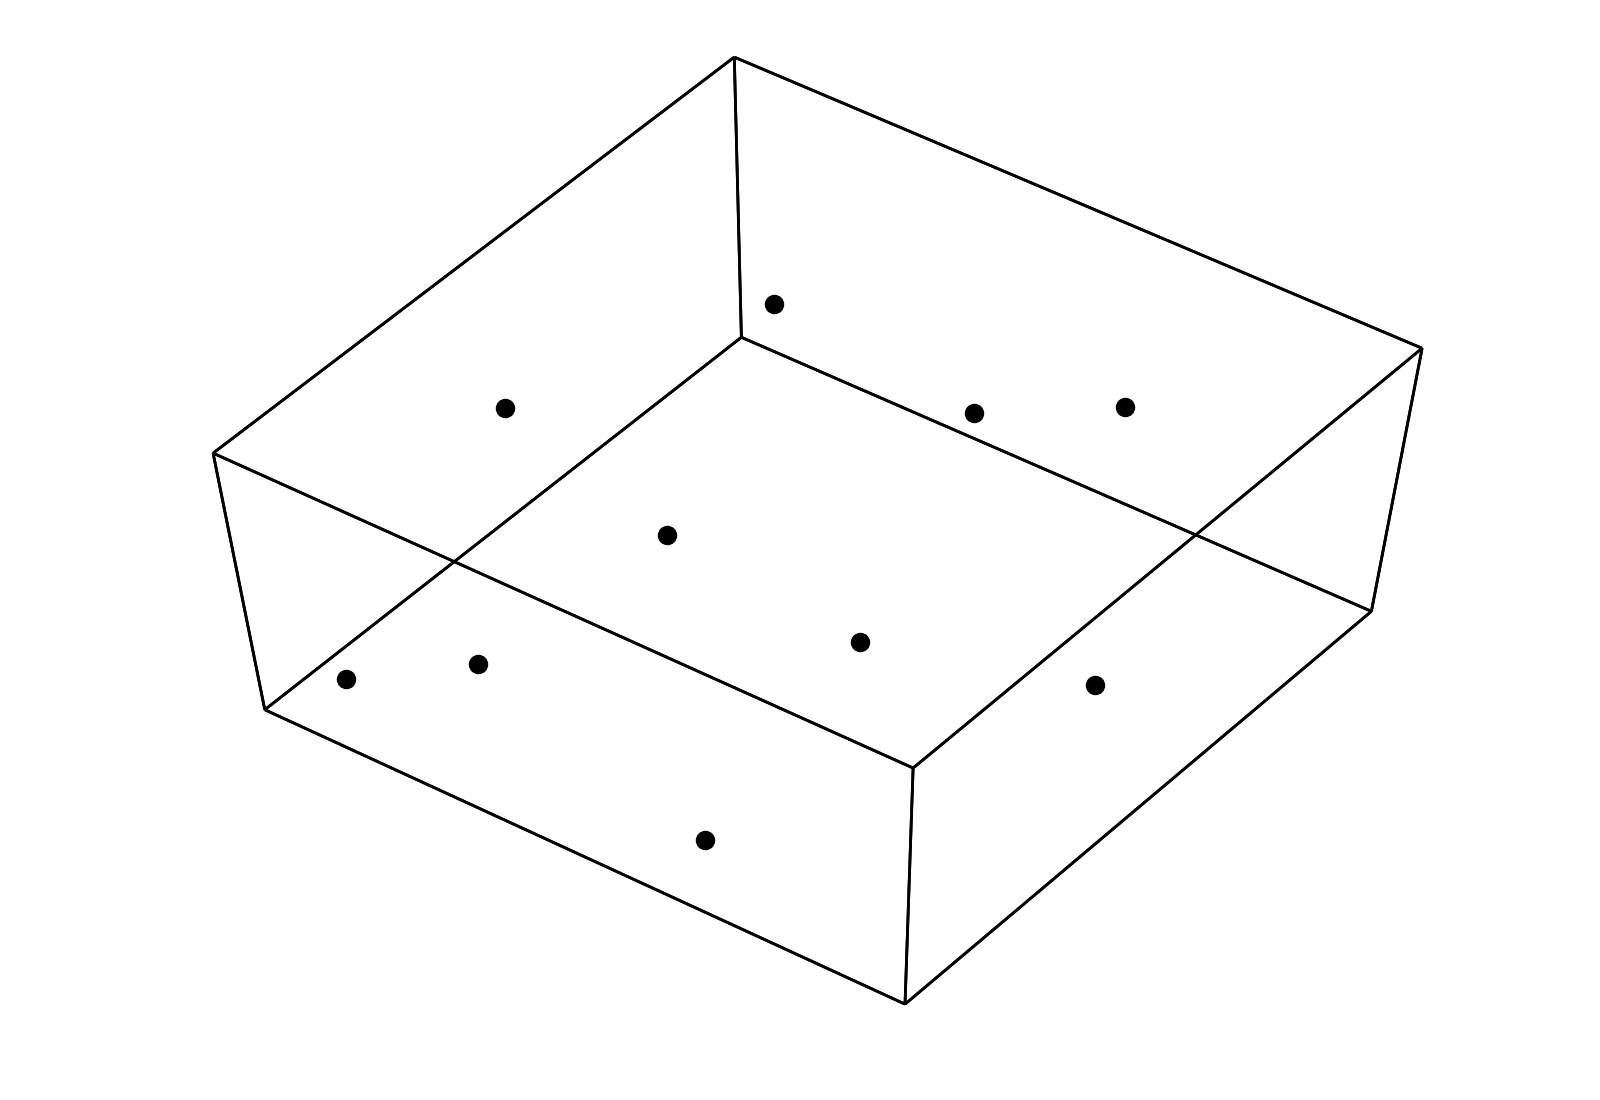

(<matplotlib.figure.Figure at 0x7ff2940c6780>,
 [array([[-40.45647196, -66.78935972, -26.44294684],
         [ 55.07965463,  -5.54226638, -13.60899055],
         [ 35.61155441, -38.93813679,  38.24765086],
         [-34.74173394,  34.47927202,   8.21012935],
         [ 25.74732948, -64.1814482 , -31.58832972],
         [-40.60062081, -23.56621375,  36.93252167],
         [ 17.55265164,  13.65363509,  43.40639846],
         [ 20.03055724,  50.60808948,  -4.59327423],
         [ -8.54908201, -72.23206631,  28.10940453],
         [-24.32028258,  -7.41431459, -28.6219573 ]])],
 None)

In [15]:
hyp.plot(tfa.get_centers(tfa.local_posterior_), 'ko')

## Compare the original vs. TFA-reduced data trajectories

<IPython.core.display.Javascript object>


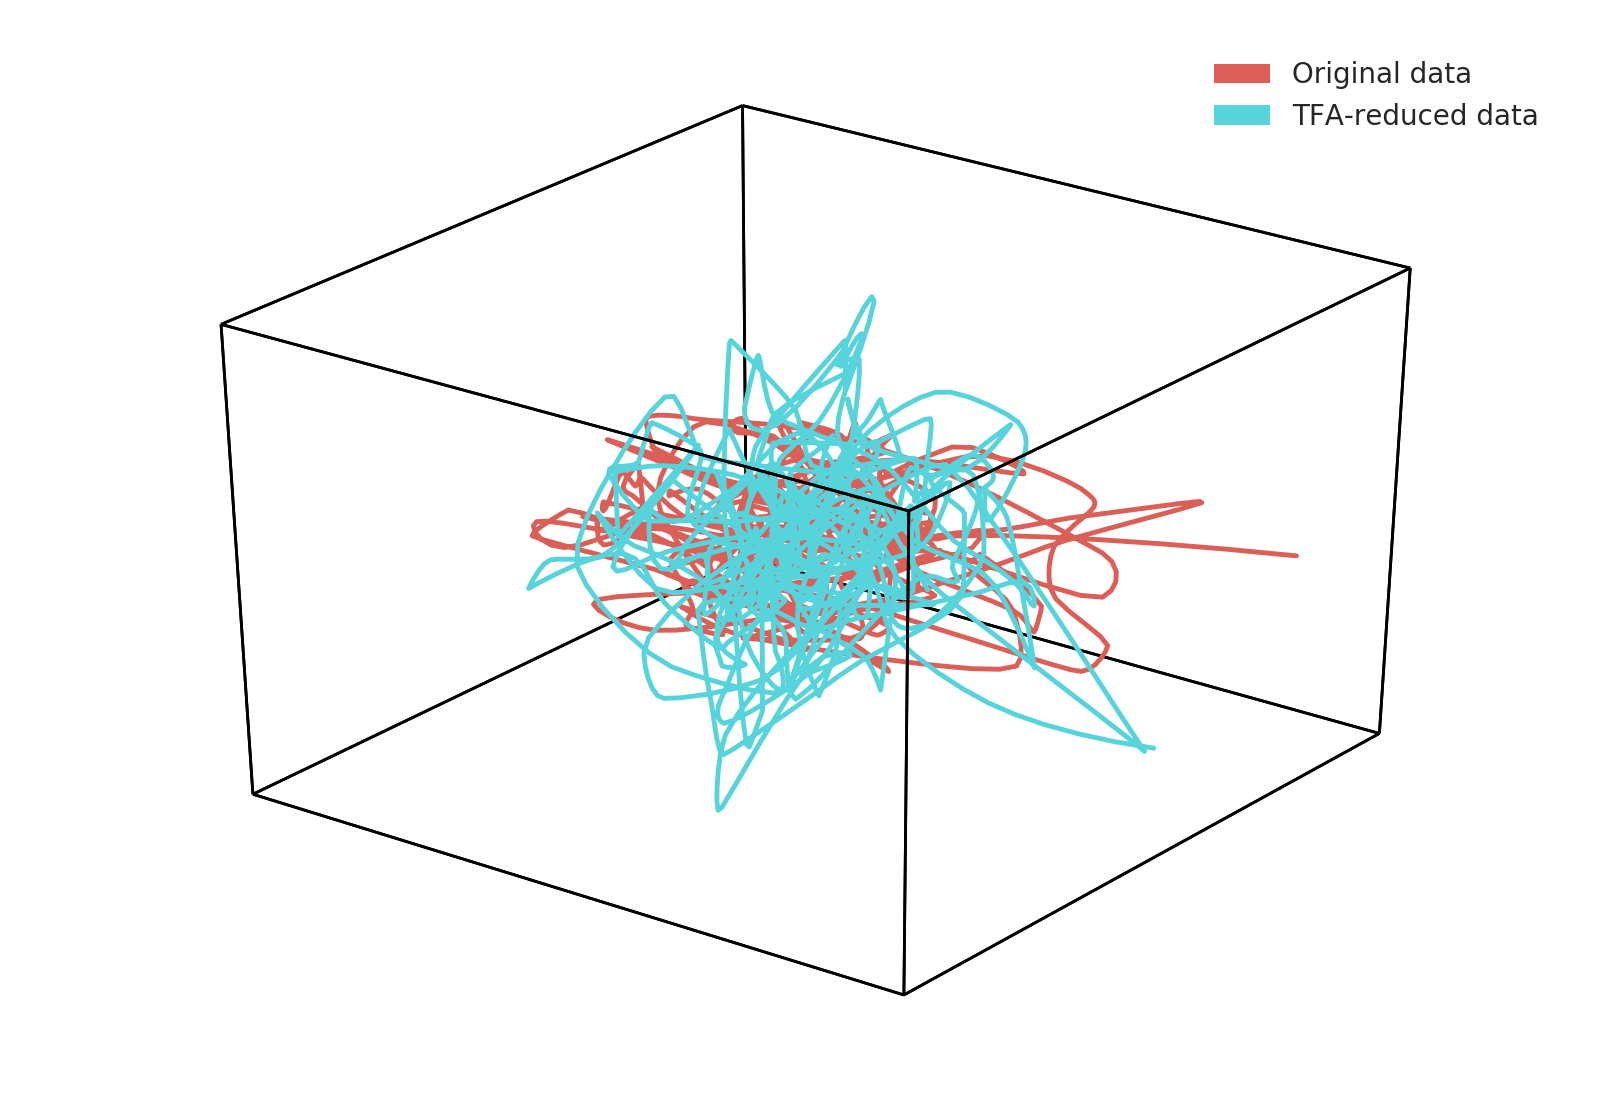

In [24]:
reduced_raw = hyp.tools.reduce(cmu_data[0]['Y'], ndims=K)
reduced_tfa = tfa.W_.T

reduced_aligned_data = hyp.plot([reduced_raw, reduced_tfa], align=True, legend=['Original data', 'TFA-reduced data'], model='FastICA', animate=True)

# Using Hierarchical Topographic Factor Analysis to finding network "hubs" in multi-subject data #

Applying [Hierarchical Topographic Factor Analysis](http://www.biorxiv.org/content/early/2017/02/07/106690) (HTFA) to a multi-subject dataset reveals a set of `K` spherical network hubs analogous to the hubs revealed by TFA.  However, HTFA finds a set of hubs that are common across all of the subjects.  Specifically, HTFA finds a common **global template** of K hubs that every subject's data reflects.  In addition, HTFA finds a **subject-specific template** (also called a **local template**) that is particular to each individual subject.  The subject-specific template specifies how each individual is *different* from the global template.

Often we want to know something about how people "in general" respond to a given experiment, so that's the scenario we'll explore here (via the global template).  However, it is sometimes interesting to also explore individual differences using the local templates.

Note: the multi-subject HTFA inference problem is substantially more computationally intensive than the single-subject TFA inference problem.  Therefore this computation is likely to take some time to complete.

In [58]:
#configure MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
if rank == 0:
    import logging
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

Zs = list(map(lambda x: x['Z'], htfa_data))
Rs = list(map(lambda x: x['R'], htfa_data))
K = 5

htfa = HTFA(K=K,
            max_global_iter=5,
            max_local_iter=2,
            voxel_ratio=0.05,
            tr_ratio=0.1,
            max_voxel=200, #max_voxel=np.max(list(map(lambda x: x.shape[0], Rs))), #set to the maximum number of voxels from any subject
            max_tr=100,
            verbose=False)
htfa.fit(Zs[0:2], Rs[0:2])




INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 1 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.tfa:TFA converged at 0 iteration.
INFO:brainiak.factoranalysis.htfa:converged at 4 outer iter


HTFA(K=5, comm=<mpi4py.MPI.Intracomm object at 0x7ff2a98e56d8>, jac='2-point',
   lower_ratio=0.02, max_global_iter=5, max_local_iter=2, max_tr=100,
   max_voxel=200, n_subj=2, nlss_loss='soft_l1', nlss_method='trf',
   threshold=0.01, tr_ratio=0.1, tr_solver=None, upper_ratio=1.8,
   verbose=False, voxel_ratio=0.05, weight_method='rr', x_scale='jac')

In [52]:
list(map(lambda x: x.shape[0], Rs))

[94537, 94537, 94537, 94537]